In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [40]:
#Lectura de información
data=pd.read_excel("preciosportf.xlsx", index_col=0)
market=pd.read_excel("Prueba.xlsx", index_col=0)

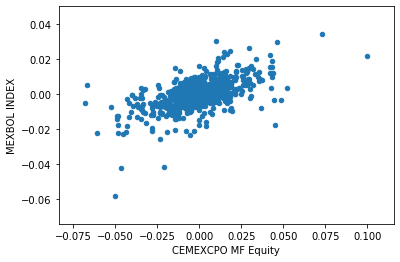

In [41]:
rets=market.pct_change() .dropna(axis=0)
[col.replace(" MF Equity ", "") for col in rets.columns]
rets.plot.scatter(x="CEMEXCPO MF Equity", y="MEXBOL INDEX")

In [42]:
N=len(rets)


In [43]:
Phi = np.c_[np.ones(N), np.ones(N), rets[["KIMBERA MF Equity", "CEMEXCPO MF Equity"]].values]

In [44]:
np.concatenate([np.identity(2)]*2, axis=1)

array([[1., 0., 1., 0.],
       [0., 1., 0., 1.]])

In [45]:
Phi =  rets.iloc[:, :-1].values
t = rets.iloc[:, [-1]]
N, M =Phi.shape

I=np.concatenate([np.identity(M)]*2, axis=1)
I=np.concatenate([I]*2, axis=0)
I.shape

(70, 70)

In [46]:
np.concatenate([*[np.ones((N,1))]]*M, axis=1).shape

(672, 35)

In [47]:
P=np.ones((N,M))

In [48]:
P.shape

(672, 35)

In [49]:
P=np.c_[P, Phi]

In [50]:
W = np.linalg.inv((P.T@P)*I)@P.T@t
W["security"]= np.concatenate([rets.columns[:-1]]*2)
W["param"]=["alpha"]*M+["beta"]*M
B=W.pivot_table(index="security", columns="param", values="MEXBOL INDEX")


Mapeamos cada uno de los activos respecto al rendimiento esperado y la volatilidad

## Optimización de los pesos

In [51]:
rend=data.pct_change().dropna()

In [52]:
rend_ports = rend.mean() * 252

In [53]:
weights = np.random.random(5)
weights/= sum(weights)
weights

array([0.35971975, 0.07439307, 0.09765561, 0.15193463, 0.31629694])

In [54]:
sum(weights)

1.0

In [55]:
#Rendimiento esperado anualizado
E_p = (rend.mean() @ weights).sum()*252
S_p = np.sqrt(weights.T@(rend.cov()*252) @ weights)

In [56]:
E_p, S_p

(0.09865736469627885, 0.1600007336517686)

In [57]:
def port_rend(weights, r):
    E_p = (r.mean() @ weights).sum()*252
    return E_p

In [58]:
port_rend(weights,rend)

0.09865736469627885

In [59]:
def port_vol(weights, r):
    S_p = np.sqrt(weights.T@(r.cov()*252) @ weights)
    return S_p

In [60]:
port_vol(weights,rend)

0.1600007336517686

In [61]:
weights_sim = np.random.random((5000,5))
weights_sim=weights_sim/weights_sim.sum(axis=1, keepdims=True)

rend_sim= np.apply_along_axis(port_rend, 1, weights_sim, r=rend)
vol_sim= np.apply_along_axis(port_vol, 1, weights_sim, r=rend)

Text(0, 0.5, 'E(r)')

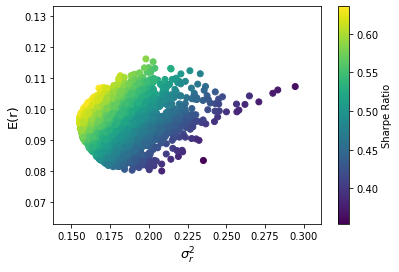

In [62]:
sharpe_ratio = rend_sim / vol_sim
plt.scatter(vol_sim, rend_sim, c=sharpe_ratio)
plt.colorbar(label="Sharpe Ratio")
plt.xlabel(r"$\sigma^2_r$", fontsize=13)
plt.ylabel("E(r)", fontsize=13)

In [63]:
rend_sim

array([0.08604179, 0.09695327, 0.09934464, ..., 0.09843968, 0.09684951,
       0.09909501])

In [64]:
vol_sim

array([0.16565352, 0.18152042, 0.22349938, ..., 0.16147514, 0.17332929,
       0.18922982])

In [65]:
rend_sim/vol_sim

array([0.5194082 , 0.53411771, 0.44449629, ..., 0.60962745, 0.5587602 ,
       0.52367545])

## Frontera eficiente

In [66]:
from scipy.optimize import minimize

In [128]:
#Funciones que utilizaremos para los contraints
N,M = rend.shape
w0 = np.random.randn(M)

def sum_weights(weights):
    return weights.sum()-1

def asig(weights,i,j):
    w1 = weights[i]
    w2 = weights[j]    
    return -(w1+w2/2) + 0.6

def asig2(weights):
    return min(weights) + 0.8

def rend_esperado(weights, E):
    return port_rend(weights, rend) - E


## Optimización sujeta a un rendimiento esperado

In [129]:
#r_min=port_rend(wp0, rend)
r_min=rend_ports.min()
r_max=rend_ports.max()

rend_max = np.linspace(r_min, r_max)

pesos_optimos = []
N, M = rend.shape
w_opt = np.random.randn(M)

for e in rend_max:
    constraints = [
        {"type": "eq", "fun": sum_weights},
        {"type": "eq", "fun": lambda w: rend_esperado(w,e)},
        {"type": "ineq", "fun": lambda w: asig(w,0,1)},
        {"type": "ineq", "fun": lambda w: asig(w,0,2)},
        {"type": "ineq", "fun": lambda w: asig(w,0,3)},
        {"type": "ineq", "fun": lambda w: asig(w,0,4)},
        {"type": "ineq", "fun": lambda w: asig(w,1,2)},
        {"type": "ineq", "fun": lambda w: asig(w,1,3)},
        {"type": "ineq", "fun": lambda w: asig(w,1,4)},
        {"type": "ineq", "fun": lambda w: asig(w,2,3)},
        {"type": "ineq", "fun": lambda w: asig(w,2,4)},
        {"type": "ineq", "fun": lambda w: asig(w,3,4)}

    ]

    
    port_opt = minimize(port_vol, w_opt,  constraints = constraints, args=rend)
    w_opt = port_opt.x
    pesos_optimos.append(w_opt)

In [130]:
r_opt = []
v_opt = []

for w in pesos_optimos:
    r_opt.append(port_rend(w,rend))
    v_opt.append(port_vol(w,rend))

r_opt = np.array(r_opt)
v_opt = np.array(v_opt)

In [142]:
pesos_optimos1 = []
N, M = rend.shape
w_opt1 = np.random.randn(M)

for e in rend_max:
    constraints = [
        {"type": "eq", "fun": sum_weights},
        {"type": "eq", "fun": lambda w: rend_esperado(w,e)},
        {"type": "ineq", "fun": lambda w: asig(w,0,1)},
        {"type": "ineq", "fun": lambda w: asig(w,0,2)},
        {"type": "ineq", "fun": lambda w: asig(w,0,3)},
        {"type": "ineq", "fun": lambda w: asig(w,0,4)},
        {"type": "ineq", "fun": lambda w: asig(w,1,2)},
        {"type": "ineq", "fun": lambda w: asig(w,1,3)},
        {"type": "ineq", "fun": lambda w: asig(w,1,4)},
        {"type": "ineq", "fun": lambda w: asig(w,2,3)},
        {"type": "ineq", "fun": lambda w: asig(w,2,4)},
        {"type": "ineq", "fun": lambda w: asig(w,3,4)},
        {"type": "ineq", "fun": asig2}
    ]

    port_opt1 = minimize(port_vol, w_opt1,  constraints = constraints, args=rend)
    w_opt1 = port_opt1.x
    pesos_optimos1.append(w_opt1)

In [143]:
r_opt1 = []
v_opt1 = []

for w in pesos_optimos1:
    r_opt1.append(port_rend(w,rend))
    v_opt1.append(port_vol(w,rend))

r_opt1 = np.array(r_opt1)
v_opt1 = np.array(v_opt1)

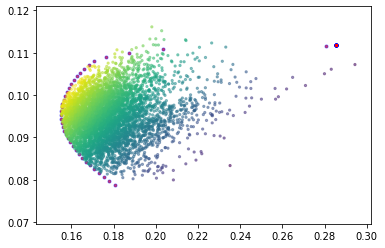

In [144]:
#Graficamos ambas fronteras
plt.scatter(v_opt,r_opt, c= "blue",linewidths=1,alpha=.5,marker = ".")
plt.scatter(v_opt1,r_opt1, c= "red",linewidths=.01,alpha=.5,marker = ".")
plt.scatter(vol_sim, rend_sim, c=sharpe_ratio, alpha = 0.5, s=5)

## Portafolio Tangencial

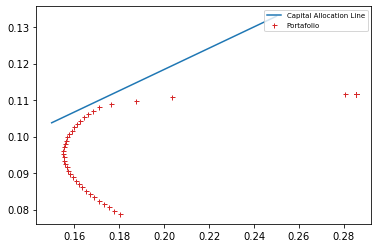

In [145]:
#Finalmente genramos la CAL junto con su gràfica, realizando el overlay con las fronteras de los 2 portafolios generados.
rf = 0.06
w0 = np.random.randn(M)

def min_func_sharpe(weights):
    return - (port_rend(weights, rend) - rf)/port_vol(weights,rend)

constraints2 = [
    {"type": "eq","fun":sum_weights}
]

f_sharpe = minimize(min_func_sharpe,w0, constraints = constraints2)
w_sharpe = f_sharpe.x
e_sharpe = port_rend(w_sharpe,rend)
vol_sharpe = port_vol(w_sharpe, rend)

sigma_c = np.linspace(.15,0.25)
sharpe = rf + sigma_c * (e_sharpe - rf) / vol_sharpe

plt.plot(sigma_c,sharpe, linestyle = "-", c= "tab:blue",label = "Capital Allocation Line")
plt.plot(v_opt,r_opt,linestyle = "",marker="+",markersize=5.0, c= "tab:red",label = "Portafolio")
plt.legend(fontsize=7, loc ='upper right' )